In [86]:
%matplotlib inline
import matplotlib.pyplot as p
import numpy as np

import matplotlib.gridspec as gridspec

In [87]:
times, fluxes, errors, _, res = zip(*np.loadtxt('./corrected_pc_wl.txt', skiprows=1))
times, fluxes, errors = map(np.array, [times, fluxes, errors])
smooth_times, smooth_fluxes = zip(*np.loadtxt('./smooth_pc_wl.txt', skiprows=1))
smooth_times, smooth_fluxes = map(np.array, [smooth_times, smooth_fluxes])

t_start = times[0]
smooth_times, times = smooth_times-t_start, times-t_start

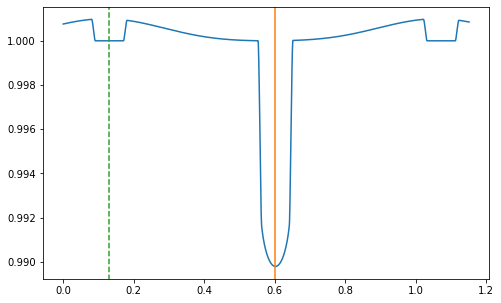

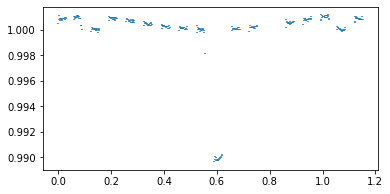

In [88]:
per = 0.94

t0 = 0.6
t1 = t0-per/2. # 0.13

p.figure(figsize=(8,5))
p.plot(smooth_times, smooth_fluxes)
p.gca().set_autoscale_on(False)
p.plot([t0]*2,[0,2])
p.plot([t1]*2,[0,2], ls='--')
p.show()

p.figure(figsize=(6,3))
p.errorbar(times, fluxes, errors, ls='None')
p.show()

In [57]:
def get_vp_allk(fname):
    source_dir = './'
    with open(source_dir+fname, 'r') as g:
        header = g.readline()
        lines = g.readlines()
    lines = [line for line in lines if not line.strip()=='' and not line[0] == '#']
        
    phases, waves, spec = zip(*[[float(val) for val in line.split(',')] for line in lines])
    phases, waves, spec = map(np.array, [phases, waves, spec])
    return phases, waves, spec

phases_model, waves_model, spec_model = get_vp_allk('PC-W18b-Met-05-TauDrag-1e3-AllK.dat')
phase_set = sorted(set(phases_model))

def get_model(ph, waves=waves_model, spec=spec_model):
    #" Simple linear interpolation of model spectra
    while ph < -180: ph += 360
    while ph > 180: ph -= 360
        
    i0 = np.argmin([abs(ps-ph) for ps in phase_set])
    ph0 = phase_set[i0]
    
    if ph < ph0:
        i1 = i0 - 1
        ph1  = phase_set[i1]
        i0, i1 = i1, i0 # swap
        ph0, ph1 = ph1, ph0
    elif ph > ph0:
        i1 = i0 + 1
        ph1 = phase_set[i1]
    else: # ph=ph0
        return spec[phases_model==ph0]
    
    spec1, spec2 = spec[phases_model==ph0], spec[phases_model==ph1]
    
    w1, w2 = (ph1-ph)/(ph1-ph0), (ph-ph0)/(ph1-ph0)
    
    return spec1*w1 + spec2*w2

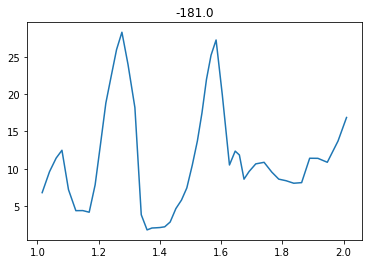

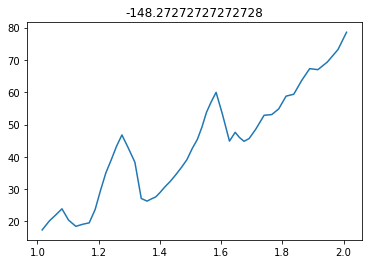

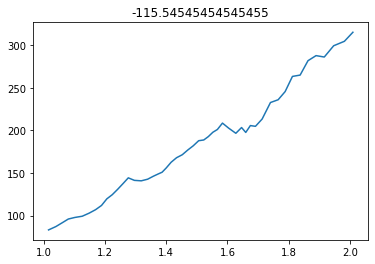

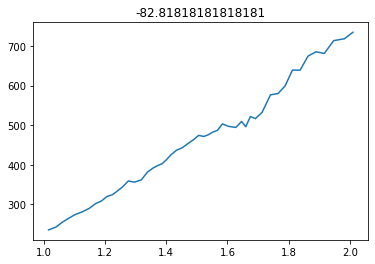

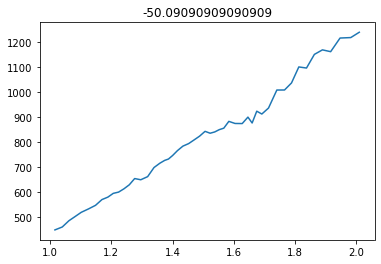

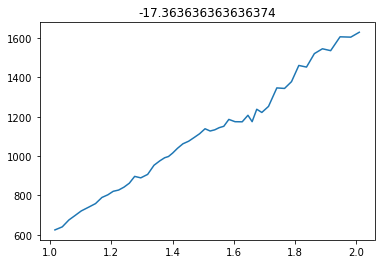

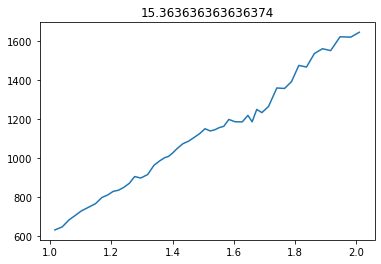

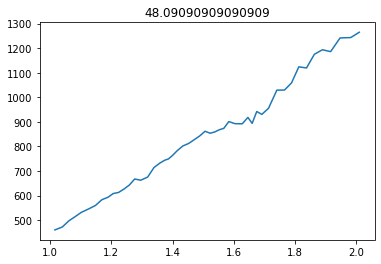

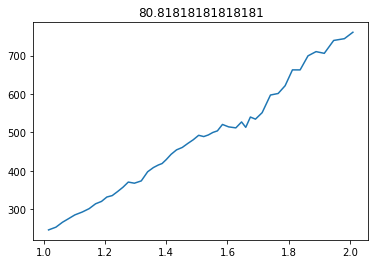

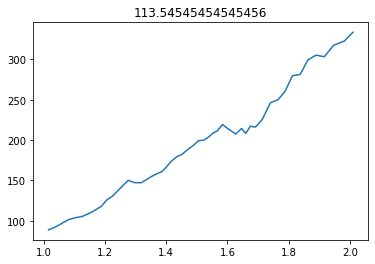

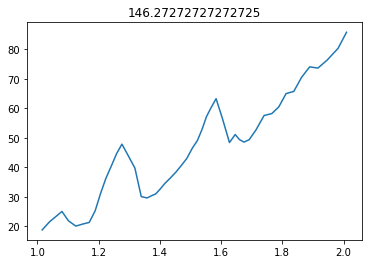

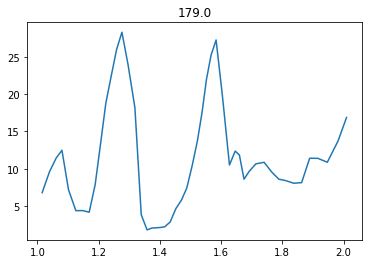

In [58]:
for ph in np.linspace(-181, 179, 12):

    k0, k1 = np.argmin(abs(waves_model-1.)), np.argmin(abs(waves_model-2.))
    if k0 > k1: k0, k1 = k1, k0
        
    fl = get_model(ph)
    
    p.figure()
    p.title(ph)
    p.plot(waves_model[phases_model==50][k0:k1], fl[k0:k1]*1e6)
    p.show()

### Data

In [59]:
import os

#source_dir2 = '/home/jacob/Project_1/emcee_run/pc_a_mr_ec/'
source_dir2 = '/home/jacob/Project_1/emcee_run/pc_a_mr_ec_shporer/analysis/'

fnames = os.listdir(source_dir2)
print('Files to work with:\n')
my_fnames = []
for fname in  fnames:
    if fname.startswith('spec'): 
        my_fnames.append(fname)
        
my_fnames = sorted(my_fnames)
for fname in my_fnames: print(fname)
# 0.28 + 0.65
# 0.4 + 0.56
# 0.0 + 0.9
def get_my_spec(fname):
    with open(source_dir2+fname, 'r') as g:
        header = g.readline()
        units = g.readline()
        lines = g.readlines()

    wave1, wave2, spec, err = \
        zip(*[ [float(val) for val in line[:-1].split()] for line in lines if not line.strip() == ''])
    wave1, wave2, spec, err = \
        map(np.array, [wave1, wave2, spec, err ])
    
    return wave1, wave2, spec, err 

Files to work with:

spec_0.062_0.092.txt
spec_0.130_0.162.txt
spec_0.277_0.309.txt
spec_0.348_0.394.txt
spec_0.418_0.438.txt
spec_0.561_0.598.txt
spec_0.637_0.669.txt
spec_0.707_0.739.txt
spec_0.778_0.810.txt
spec_0.848_0.880.txt
spec_0.919_0.940.txt


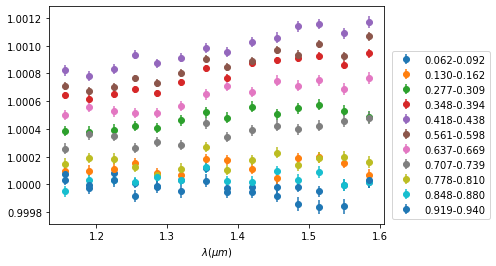

In [60]:
my_dict = {}

for fname in my_fnames:
    wv1, wv2, spec, err = get_my_spec(fname)
    # Let make a dict
    ph1, ph2 = float(fname.split('_')[1]), float(fname[:-4].split('_')[2])
    
    p.errorbar(np.mean([wv1,wv2], axis=0), spec, err, ls='None', marker='o', 
               label='{:.3f}-{:.3f}'.format(ph1,ph2))
    
    #if ph1 > 0.5: ph1, ph2 = 1-ph2, 1-ph1 
    my_dict[fname] = (np.mean([wv1,wv2],axis=0), spec, err, (ph1, ph2))
    
    
p.legend(loc='lower left', bbox_to_anchor=(1.01,0))
#p.ylim([1+500e-6,1+900e-6])
p.xlabel(r'$\lambda (\mu m)$')
p.show()

In [67]:
def get_data(ph, dic=my_dict):
    #" Simple linear interpolation of pc spectral data
    while ph < -180: ph += 360
    while ph > 180: ph -= 360
        
    data_phis, order = zip(*sorted(zip([ np.mean(dic[fname][-1])*360-180 for fname in dic], np.arange(len(dic)))))
    
    i0 = np.argmin([abs(ps-ph) for ps in data_phis])
    ph0 = data_phis[i0]
    
    data_wv0, data_fl0, data_er0, data_ph0 = dic[list(dic.keys())[order[i0]]]
    
    try:
        if ph < ph0:
            i1 = i0 - 1
            ph1  = data_phis[i1]
            i0, i1 = i1, i0 # swap
            ph0, ph1 = ph1, ph0
        elif ph > ph0:
            i1 = i0 + 1
            ph1 = data_phis[i1]
        else: # ph=ph0
            return data_wv0, data_fl0, data_er0

        data_wv1, data_fl1, data_er1, data_ph1 = dic[list(dic.keys())[order[i1]]]

        w1, w2 = (ph1-ph)/(ph1-ph0), (ph-ph0)/(ph1-ph0)
        
        data_fl = data_fl0*w1 + data_fl1*w2
        data_er = np.sqrt((data_er0*w1)**2 + (data_er1*w2)**2)
    
        return data_wv1, data_fl, data_er
    except IndexError:
        # Return end
        return data_wv0, data_fl0, data_er0

In [79]:
# Pick key spectra
specnames = list(my_dict.keys())
key_specs = [ specnames[4], specnames[2], specnames[-1]]

### Sphere

(2325, 4651, 4) to (24, 47)


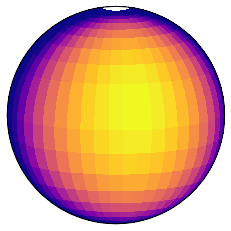

In [68]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio

img = imageio.imread('w18_thermal_map_pure.png')
_img = np.mean(img, axis=-1)[::100,::100]

print(img.shape, 'to', _img.shape)

def main():
    fig = p.figure()
    crs = ccrs.Orthographic(0,10)
    ax = p.axes(projection=crs)
    
    ax.imshow(_img, transform=ccrs.Mercator(), cmap='plasma', vmin=180, vmax=255)
    
    p.show()
    
main()

# deg per dx
dpdx = 360./_img.shape[1]

## All

In [69]:
cdata = 'C1'

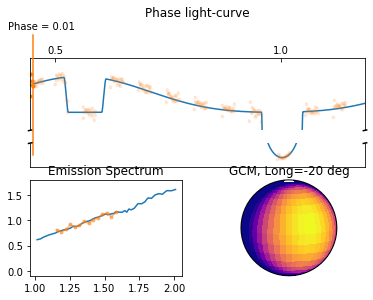

Time taken: 0.9s


In [70]:
import time
tt0 = time.time()

phi = -20

# phi degrees from 0 dayside
t = phi/360.*per + t1

h = 3
fig = p.figure()
gs = gridspec.GridSpec(ncols=2, nrows=3, height_ratios=[h, 1, h+1])

ax = fig.add_subplot(gs[0, :])
ax.set_title('Phase light-curve', y=1.5)
ax2 = fig.add_subplot(gs[1,:])

# Plot the data
alph = 0.1
ax.plot(smooth_times, smooth_fluxes)
ax.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)
ax2.plot(smooth_times, smooth_fluxes)
ax2.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)

# Variable progress markers
data1, = ax.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
data2, = ax2.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
progline = ax2.plot([t]*2,[0.99,1], clip_on=False)
proglabel = ax2.text(t-0.06, 1.0005, 'Phase = {:.2f}'.format(t/per))
#data2.set_data(times, fluxes)


ax.set_ylim(0.9995,1.0015)
ax2.set_ylim(0.989,0.991)
ax.set_xlim(0, 0.8)
ax2.set_xlim(0, 0.8)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(direction='in')
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_xticks([])

ax.set_xticks([t1, t0])
ax.set_xticklabels(['0.5', '1.0'])


d = .005 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((-d,+d),(-d,+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d*h,1+d*h), **kwargs)
ax2.plot((1-d,1+d), (1-d*h,1+d*h), **kwargs)


#######################
## Emission Spectrum ##
#######################

ax3 = fig.add_subplot(gs[2, 0])

fl = get_model(phi)
ax3.plot(waves_model[phases_model==50][k0:k1], np.array(fl[k0:k1])*1e3)

data_wv, data_fl, data_er = get_data(phi)
ax3.plot(data_wv, (data_fl-1)*1e3, alpha=0.5, marker='o', ms=3)

#ax3.set_yticks([])
ax3.set_ylim(-.1, 1.8)
ax3.set_title('Emission Spectrum')

#####################
## Sphere GCM plot ##
#####################

crs = ccrs.Orthographic(0,10)
ax4 = fig.add_subplot(gs[2, 1], projection=crs)
ax4.set_title('GCM, Long={:3} deg'.format(int(phi)))
_img_roll = np.roll(_img, int(-phi/dpdx), axis=1)
ax4.imshow(_img_roll, transform=ccrs.Mercator(), cmap='plasma', vmin=180, vmax=255)

p.show()

tt1 = time.time()
print('Time taken: {:.1f}s'.format(tt1-tt0))

## Film

In [71]:
import matplotlib.animation as manimation

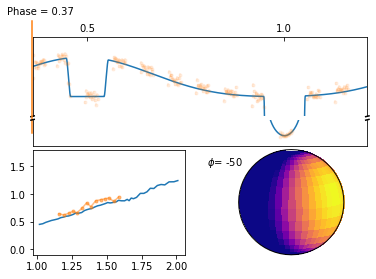

-25.920000000000016
-74.51999999999998
154.62


In [ ]:
tt0 = time.time()

mp4_file = '/home/jacob/Documents/JRF_Jesus/vid.mp4'
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='w18_pc', artist='jarcangeli',
                comment='Phase curve, spectra, and GCM in time')
writer = FFMpegWriter(fps=10, metadata=metadata)


phi = -50

# phi degrees from 0 dayside
t = phi/360.*per + t1

h = 3
fig = p.figure()
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[h, 1, h+1])

ax = fig.add_subplot(gs[0, :])
#ax.set_title('Phase light-curve', y=1.5)
ax2 = fig.add_subplot(gs[1,:])

# Plot the data
alph = 0.1
cdata = 'C1'
ax.plot(smooth_times, smooth_fluxes)
ax.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)
ax2.plot(smooth_times, smooth_fluxes)
ax2.errorbar(times, fluxes, errors, marker='o', ms=3, ls='None', alpha=alph, color=cdata)

# Variable progress markers
data1, = ax.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
data2, = ax2.plot(times[times<t], fluxes[times<t], marker='o', ms=3, ls='None', color=cdata)
l1, l2 = 0.99, 0.9985
progline, = ax2.plot([t]*2,[l1, l2], clip_on=False)
tx1, tx2 = 0.06, 0.999
proglabel = ax2.text(t-tx1, tx2, 'Phase = {:.2f}'.format(phi/360.*per+0.5))
ax.set_ylim(0.9995,1.0015)
ax2.set_ylim(0.989,0.991)
ax.set_xlim(0, 0.8)
ax2.set_xlim(0, 0.8)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(direction='in')
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_xticks([])

ax.set_xticks([t1, t0])
ax.set_xticklabels(['0.5', '1.0'])


d = .005 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((-d,+d),(-d,+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d*h,1+d*h), **kwargs)
ax2.plot((1-d,1+d), (1-d*h,1+d*h), **kwargs)


ax3 = fig.add_subplot(gs[2, 0])
fl = get_model(phi)
spec3, = ax3.plot(waves_model[phases_model==50][k0:k1], np.array(fl[k0:k1])*1e3)
data_wv, data_fl, data_er = get_data(phi)
data3, = ax3.plot(data_wv, (data_fl-1)*1e3, alpha=0.5, marker='o', ms=3)
#ax3.set_yticks([])
ax3.set_ylim(-.1, 1.8)
#ax3.set_title('Emission Spectrum')


crs = ccrs.Orthographic(0,10)
ax4 = fig.add_subplot(gs[2, 1], projection=crs)
#ax4.set_title('GCM, Long={:4} deg'.format(int(phi)))
_img_roll = np.roll(_img, int(-phi/dpdx), axis=1)
sphere = ax4.imshow(_img_roll, transform=ccrs.Mercator(), cmap='plasma', vmin=180, vmax=255)
phlabel = ax4.text(-0.3, 0.85, '$\phi$={:4}'.format(phi), transform=ax4.transAxes)

p.subplots_adjust(hspace=0.05)
p.show()

#raise

key_j = 0

with writer.saving(fig, mp4_file, dpi=100):
    for phi in np.linspace(phi, 260, 60):
        t = phi/360.*per + t1

        data1.set_data(times[times<t], fluxes[times<t])
        data2.set_data(times[times<t], fluxes[times<t])

        progline.set_data([t]*2,[l1,l2])
        proglabel.set_position((t-tx1, tx2))
        proglabel.set_text('Phase = {:.2f}'.format(phi/360.*per+0.5))
        phlabel.set_text('$\phi$={:.0f}'.format(phi))

        fl = get_model(phi)
        spec3.set_data(waves_model[phases_model==50][k0:k1], np.array(fl[k0:k1])*1e3)
        data_wv, data_fl, data_er = get_data(phi)
        data3.set_data(data_wv, (data_fl-1)*1e3)
        
        #ax4.set_title('GCM, Long={:4} deg'.format(int(phi)))
        _img_roll = np.roll(_img, int(-phi/dpdx), axis=1)
        #sphere.set_data(_img_roll)
        del sphere
        sphere = ax4.imshow(_img_roll, transform=ccrs.Mercator(), cmap='plasma', vmin=180, vmax=255)

        if key_j < len(key_specs):
            name = key_specs[key_j]
            data_wv1, data_fl1, data_er1, data_ph1 = my_dict[name]
            ph_key = np.mean(data_ph1)*360-180
            if phi > ph_key:
                print(ph_key)
                ax3.errorbar(data_wv1, (data_fl1-1)*1e3, data_er1*1e3, color='k', capsize=3)
                key_j += 1
            
        writer.grab_frame()

tt1 = time.time()
print('Time taken: {:.1f}s'.format(tt1-tt0))